In [77]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)
from collections import defaultdict

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path
from scipy.signal import hilbert, savgol_filter
from datetime import datetime

In [2]:
model1 = sbm.SeismicCNN.from_pretrained("base", version_str = '1')
model2 = sbm.SeismicCNN.from_pretrained("base", version_str = '2')
model3 = sbm.SeismicCNN.from_pretrained("base", version_str = '3')

In [125]:
sns.set_style("whitegrid")
sns.set_context("talk")


start = '2025-06-25T0:0:0'
starttime = obspy.UTCDateTime(start) 
endtime = obspy.UTCDateTime(start) + 24*3600
network = 'CC'
station = 'PARA'
channel = '*H*'
loc = '*'

client = Client('IRIS')
st = client.get_waveforms(starttime = starttime, 
                    endtime = endtime, 
                    network = network, 
                    station = station, 
                    channel = channel, 
                    location = loc)



probs_st = model3.annotate(st, stride = 500) 
probs = np.array(probs_st)

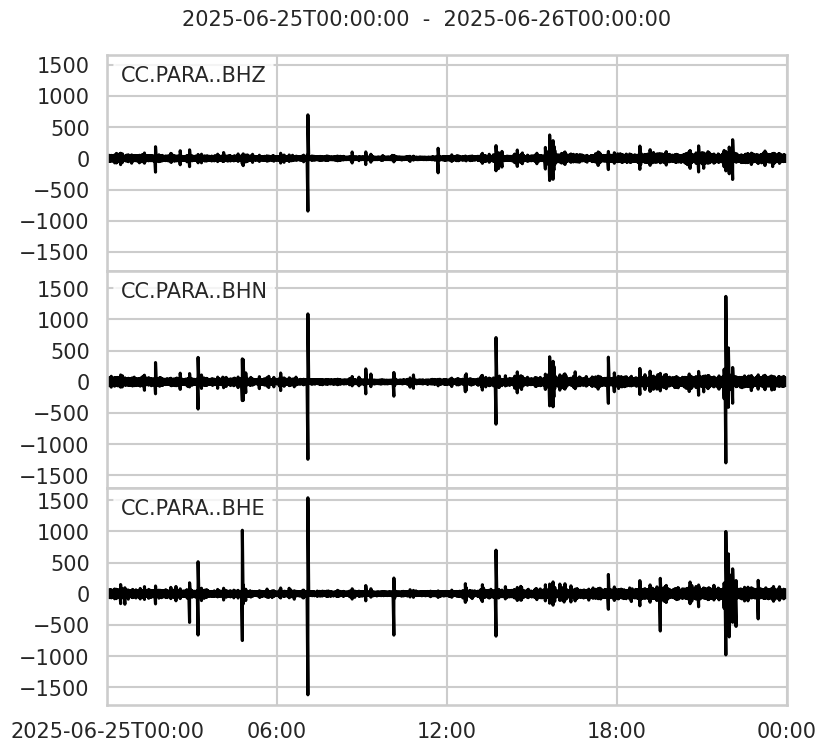

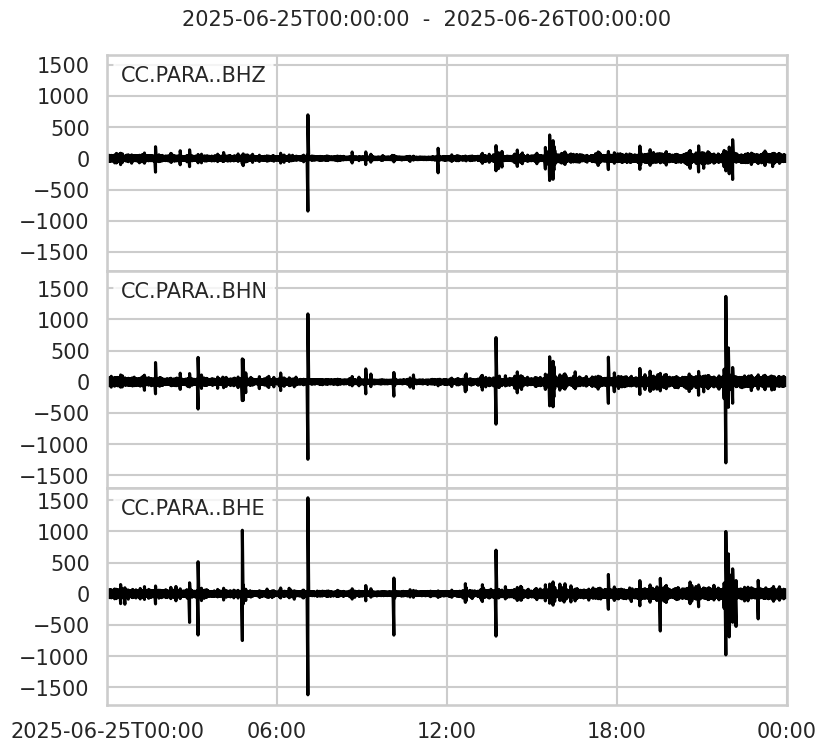

In [126]:
st.detrend('linear')
st.taper(0.001)
st.filter('bandpass', freqmin = 1, freqmax= 20)
st.plot()

In [10]:
# processing waveforms. 
st.resample(50)
st.detrend('linear')
st.taper(0.001)
st.filter('bandpass', freqmin = 1, freqmax = 10)





# ───── Waveform + smooth envelope ──────────────────────────────────────────
tr_z   = st.select(component="Z")[0]
fs     = tr_z.stats.sampling_rate
wave_t = tr_z.times()
wave_y = tr_z.data  #/ np.abs(tr_z.data).max()



raw_env    = np.abs(hilbert(tr_z.data))
win        = int(5 * fs) | 1            # ~5-s Savitzky window, must be odd
smooth_env = savgol_filter(raw_env, win, 3)


# --- standard-scaler version ----------------------------------------


mu  = smooth_env.mean()
sig = smooth_env.std(ddof=0)        # population σ; use ddof=1 for sample σ
smooth_env = (smooth_env - mu) / sig


# ───── Probabilities (already from model3) ─────────────────────────────────
prob_t  = probs_st[2].times() + 50      # (Nwin,) time stamps
prob_eq = probs[0]
prob_px = probs[1]                       # explosion P_px  (Nwin,)
prob_su = probs[3]                       # surface   P_su  (Nwin,)


# ───── Resample envelope onto prob grid & weight ───────────────────────────
env_resamp = np.interp(prob_t, wave_t, smooth_env)
w_px = prob_px * env_resamp
w_su = prob_su * env_resamp
w_eq = prob_eq * env_resamp





def smooth_moving_avg(x, window=5):
    pad_width = window // 2
    padded = np.pad(x, (pad_width, pad_width), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')

# Example usage
#smoothed_series = smooth_moving_avg(original_series, window=5)


s_px = smooth_moving_avg(prob_px, window = 5)
s_eq = smooth_moving_avg(prob_eq, window = 5)
s_su = smooth_moving_avg(prob_su, window = 5)

mins = 15
for i in range(int(int(60/mins)*24)):
        # ───── Plot ----------------------------------------------------------------
        fig, (ax0, ax1, ax2) = plt.subplots(
            3, 1, figsize=(12, 7), sharex=True,
            gridspec_kw=dict(height_ratios=[1, 2, 2], hspace=0.05)
        )
        
        w_data = wave_y[int(i*mins*60)*50:int((i+1)*mins*60)*50]

        # 1) waveform + envelope
        ax0.plot(wave_t[int(i*mins*60)*50:int((i+1)*mins*60)*50], w_data/abs(max(w_data)), color="black", lw=0.8, label="Waveform (Z)")
        #ax0.plot(wave_t, smooth_env, color="darkorange", lw=1.4, label="Envelope")
        ax0.set_ylim(-1, 1)
        ax0.set_ylabel("Norm. amp.")
        ax0.set_title("Waveform, Envelope, Probabilities & Envelope-weighted Prob.", weight="bold")
        ax0.legend(frameon=False, loc="upper right")
        ax0.tick_params(axis="x", length=0)

        
        
        # 2) raw probabilities
        ax1.plot(prob_t, prob_px, lw=2, label="Explosion $P_{px}$",
                 color=sns.color_palette("Set2")[1])
        #ax1.plot(prob_t, prob_eq, lw=2, label="Explosion $P_{eq}$",
        #         color=sns.color_palette("Set2")[2])
        #ax1.plot(prob_t, prob_su, lw=2, label="Surface  $P_{su}$",
        #         color=sns.color_palette("Set2")[0])
        ax1.axhline(0.5, color="gray", ls="--", lw=0.8)
        ax1.set_ylabel("Probability")
        #ax1.set_ylim(0, 1.02)
        ax1.legend(frameon=False, loc="upper right")

        # 3) envelope-weighted probabilities
        ax2.plot(prob_t, s_px, lw=2, label="$P_{px}\\times$Env.",
                 color=sns.color_palette("Set2")[1])
        ax2.plot(prob_t, s_eq, lw=2, label="$P_{eq}\\times$Env.",
                 color=sns.color_palette("Set2")[2])
        ax2.plot(prob_t, s_su, lw=2, label="$P_{su}\\times$Env.",
                 color=sns.color_palette("Set2")[0])
        ax2.set_xlabel("Time since trace start (s)")
        ax2.set_ylabel("Env-weighted Prob.")
        #ax2.set_ylim(-1, 2)
        ax2.legend(frameon=False, loc="upper right")




        ax0.set_xlim(i*mins*60, (i+1)*mins*60)
        ax1.set_xlim(i*mins*60, (i+1)*mins*60)
        ax2.set_xlim(i*mins*60, (i+1)*mins*60)
        
        sns.despine()
        plt.tight_layout()
        plt.show()


TypeError: Integer expected

In [6]:
prob_px

UW.STAR.01.SeismicCNN_px | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples

In [7]:
env_resamp

array([-0.20658529, -0.19093182, -0.33186127, ..., -0.427431  ,
       -0.17751039, -0.22360586])

In [14]:
probs[4]

UW.STAR.01.SeismicCNN_eq | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples

In [16]:
obspy.Stream(probs_st)

16 Trace(s) in Stream:
UW.STAR.01.SeismicCNN_eq | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_px | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_no | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_su | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_eq | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_px | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_no | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_su | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_eq | 2025-06-25T08:03:29.400000Z - 2025-06-25T09:31:49.400000Z | 0.1 Hz, 531 samples
UW.STAR.01

In [17]:
st

15 Trace(s) in Stream:
UW.STAR.01.EHE | 2025-06-25T00:00:00.000000Z - 2025-06-25T07:00:01.180000Z | 50.0 Hz, 1260060 samples
UW.STAR.01.EHE | 2025-06-25T07:00:07.500000Z - 2025-06-25T07:01:02.480000Z | 50.0 Hz, 2750 samples
UW.STAR.01.EHE | 2025-06-25T07:01:03.400000Z - 2025-06-25T08:01:04.380000Z | 50.0 Hz, 180050 samples
UW.STAR.01.EHE | 2025-06-25T08:02:39.400000Z - 2025-06-25T09:32:42.380000Z | 50.0 Hz, 270150 samples
UW.STAR.01.EHE | 2025-06-25T09:33:16.400000Z - 2025-06-25T23:59:59.980000Z | 50.0 Hz, 2600180 samples
UW.STAR.01.EHN | 2025-06-25T00:00:00.000000Z - 2025-06-25T07:00:01.180000Z | 50.0 Hz, 1260060 samples
UW.STAR.01.EHN | 2025-06-25T07:00:07.500000Z - 2025-06-25T07:01:02.480000Z | 50.0 Hz, 2750 samples
UW.STAR.01.EHN | 2025-06-25T07:01:03.400000Z - 2025-06-25T08:01:04.380000Z | 50.0 Hz, 180050 samples
UW.STAR.01.EHN | 2025-06-25T08:02:39.400000Z - 2025-06-25T09:32:42.380000Z | 50.0 Hz, 270150 samples
UW.STAR.01.EHN | 2025-06-25T09:33:16.400000Z - 2025-06-25T23:59:59.98

In [18]:
probs_st

16 Trace(s) in Stream:
UW.STAR.01.SeismicCNN_eq | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_px | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_no | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_su | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_eq | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_px | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_no | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_su | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_eq | 2025-06-25T08:03:29.400000Z - 2025-06-25T09:31:49.400000Z | 0.1 Hz, 531 samples
UW.STAR.01

In [19]:
probs

array([<obspy.core.trace.Trace object at 0x7ffa68172070>,
       <obspy.core.trace.Trace object at 0x7ffa6801da60>], dtype=object)

In [20]:
probs_st

16 Trace(s) in Stream:
UW.STAR.01.SeismicCNN_eq | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_px | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_no | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_su | 2025-06-25T00:00:50.000000Z - 2025-06-25T06:59:10.000000Z | 0.1 Hz, 2511 samples
UW.STAR.01.SeismicCNN_eq | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_px | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_no | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_su | 2025-06-25T07:01:53.400000Z - 2025-06-25T08:00:13.400000Z | 0.1 Hz, 351 samples
UW.STAR.01.SeismicCNN_eq | 2025-06-25T08:03:29.400000Z - 2025-06-25T09:31:49.400000Z | 0.1 Hz, 531 samples
UW.STAR.01

In [31]:
# we want to smoothen out the probabilities here. 
def smooth_moving_avg(x, window=5):
    pad_width = window // 2
    padded = np.pad(x, (pad_width, pad_width), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')


In [88]:
def detect_event_windows(prob_series, enter_thr=0.15, exit_thr=0.15, peak_thr=0.5):
    in_event = False
    events = []
    start = None
    max_val = -np.inf
    running_vals = []

    for i, val in enumerate(prob_series):
        if not in_event and val >= enter_thr:
            start = i
            max_val = val
            running_vals = [val]
            in_event = True
        elif in_event:
            running_vals.append(val)
            max_val = max(max_val, val)
            if val < exit_thr:
                end = i
                if max_val >= peak_thr:
                    mean_val = np.mean(running_vals)
                    events.append({
                        "start": start,
                        "end": end,
                        "max_prob": max_val,
                        "mean_prob": mean_val
                    })
                in_event = False

    # Handle if still in event at end of series
    if in_event and max_val >= peak_thr:
        mean_val = np.mean(running_vals)
        events.append({
            "start": start,
            "end": len(prob_series) - 1,
            "max_prob": max_val,
            "mean_prob": mean_val
        })

    return events


In [26]:
sns.set_style("whitegrid")
sns.set_context("talk")


start = '2025-06-25T0:0:0'
starttime = obspy.UTCDateTime(start) 
endtime = obspy.UTCDateTime(start) + 24*3600
network = 'UW'
station = 'STAR'
channel = '*H*'
loc = '*'

client = Client('IRIS')
st = client.get_waveforms(starttime = starttime, 
                    endtime = endtime, 
                    network = network, 
                    station = station, 
                    channel = channel, 
                    location = loc)



probs_st = model3.annotate(st, stride = 500) 



eq_prob_traces = probs_st.select(channel = 'SeismicCNN_eq')
px_prob_traces = probs_st.select(channel = 'SeismicCNN_px')
no_prob_traces = probs_st.select(channel = 'SeismicCNN_no')
su_prob_traces = probs_st.select(channel = 'SeismicCNN_su')



st_time = []
ed_time = []
for i in range(len(su_prob_traces)):
    times = su_prob_traces[i].times()
    x = np.array(su_prob_traces[i])
    s_su = smooth_moving_avg(x, 5)
    events = detect_event_windows(s_su)
    
    for j in range(len(events)):
        
        st_time.append(times[events[j]['start']])
        ed_time.append(times[events[j]['end']])
    
    
    
df = pd.DataFrame([])
df['starttime'] = st_time
df['endtime'] = ed_time
df['label'] = 'surface'
df['date'] =  '2025-06-25T0:0:0'



In [71]:
st_time = []
ed_time = []
for i in range(len(su_prob_traces)):
    times = su_prob_traces[i].times()
    x = np.array(su_prob_traces[i])
    s_su = smooth_moving_avg(x, 5)
    events = detect_event_windows(s_su)
    
    for j in range(len(events)):
        
        st_time.append(times[events[j]['start']])
        ed_time.append(times[events[j]['end']])
    

In [75]:
df = pd.DataFrame([])
df['starttime'] = st_time
df['endtime'] = ed_time
df['label'] = 'surface'
df['date'] =  '2025-06-25T0:0:0'


,starttime,endtime,label,date
0,1790.0,1870.0,surface,2025-06-25T0:0:0
1,3990.0,4060.0,surface,2025-06-25T0:0:0
2,8860.0,8950.0,surface,2025-06-25T0:0:0
3,9330.0,9410.0,surface,2025-06-25T0:0:0
4,12820.0,12890.0,surface,2025-06-25T0:0:0
...,...,...,...,...
57,46020.0,46090.0,surface,2025-06-25T0:0:0
58,47410.0,47490.0,surface,2025-06-25T0:0:0
59,49520.0,49590.0,surface,2025-06-25T0:0:0
60,49960.0,50080.0,surface,2025-06-25T0:0:0


In [59]:
s_su_0

array([0.00040987, 0.00031236, 0.00100078, ..., 0.03388524, 0.032882  ,
       0.03481671])

In [64]:
events = detect_event_windows(s_su_0)

In [52]:
time1 = su_prob_traces[0].times()[179]
time2 = su_prob_traces[0].times()[187]

In [53]:
time1

1790.0

In [54]:
time2

1870.0

In [55]:
st_0  = st.select(channel= 'EHZ')[0]


In [56]:
st_data = np.array(st_0)

[]

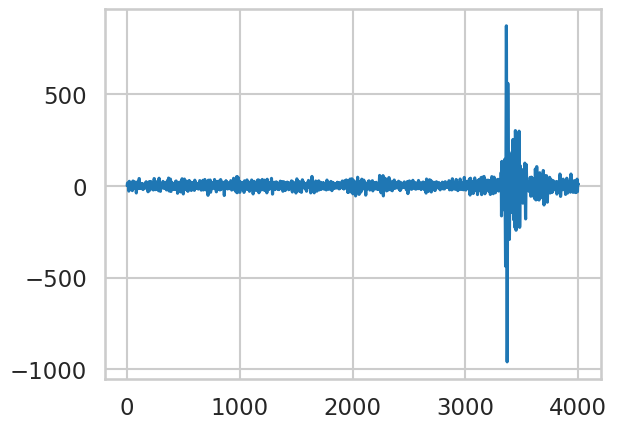

In [57]:
plt.plot(st_data[int(time1*50):int(time2*50)])
plt.plot()

In [49]:
st_0

UW.STAR.01.EHZ | 2025-06-25T00:00:00.000000Z - 2025-06-25T07:00:01.180000Z | 50.0 Hz, 1260060 samples

In [61]:
df = pd.DataFrame()
df

""


In [ ]:
# we want to smoothen out the probabilities here. 
def smooth_moving_avg(x, window=5):
    pad_width = window // 2
    padded = np.pad(x, (pad_width, pad_width), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')




def detect_event_windows(prob_series, enter_thr=0.15, exit_thr=0.15, peak_thr=0.5):
    in_event = False
    events = []
    start = None
    max_val = -np.inf
    running_vals = []

    for i, val in enumerate(prob_series):
        if not in_event and val >= enter_thr:
            start = i
            max_val = val
            running_vals = [val]
            in_event = True
        elif in_event:
            running_vals.append(val)
            max_val = max(max_val, val)
            if val < exit_thr:
                end = i
                if max_val >= peak_thr:
                    mean_val = np.mean(running_vals)
                    events.append({
                        "start": start,
                        "end": end,
                        "max_prob": max_val,
                        "mean_prob": mean_val
                    })
                in_event = False

    # Handle if still in event at end of series
    if in_event and max_val >= peak_thr:
        mean_val = np.mean(running_vals)
        events.append({
            "start": start,
            "end": len(prob_series) - 1,
            "max_prob": max_val,
            "mean_prob": mean_val
        })

    return events


In [128]:
stns_list = ['UW.STAR', 'UW.RCM', 'CC.PARA']


# Setup
client = Client('IRIS')
station = 'STAR'
network = 'UW'
channel = '*H*'
loc = '*'
stride = 500

# Your smoothing and detection functions should be defined above this block:
# - smooth_moving_avg
# - detect_event_windows

def detect_events_for_day(day_str, network, station, channel, loc):
    try:
        starttime = UTCDateTime(day_str)
        endtime = starttime + 24 * 3600

        # Get waveform and model probabilities
        st = client.get_waveforms(starttime=starttime, endtime=endtime,
                                  network=network, station=station,
                                  channel=channel, location=loc)
        
        probs_st = model3.annotate(st, stride=stride)
        su_prob_traces = probs_st.select(channel='SeismicCNN_su')

        st_time, ed_time, max_prob, mean_prob = [], [], [], []

        for tr in su_prob_traces:
            times = tr.times()
            probs = np.array(tr)
            s_su = smooth_moving_avg(probs, 5)
            events = detect_event_windows(s_su)

            for evt in events:
                st_time.append(times[evt['start']])
                ed_time.append(times[evt['end']])
                max_prob.append(evt['max_prob'])
                mean_prob.append(evt['mean_prob'])

        # Return as DataFrame
        df = pd.DataFrame({
            "starttime": st_time,
            "endtime": ed_time,
            "label": "surface",
            "date": day_str,
            "max_prob": max_prob,
            "mean_prob": mean_prob
        })
        return df
    
    except Exception as e:
        print(f"Error on {day_str}: {e}")
        return pd.DataFrame()  # Empty if failure


In [130]:
for stn in stns_list:

    net = stn.split('.')[0]
    sta = stn.split('.')[1]
    chn = '*H*'
    loc = '*'
    
    # Generate all days from 2025-06-25 to today
    date_range = pd.date_range("2025-06-25", datetime.utcnow().date())
    all_detections = []

    for day in tqdm(date_range):
        print(f"Processing {day.date()}...")
        df_day = detect_events_for_day(day.strftime("%Y-%m-%d"), net, sta, chn, loc)
        if not df_day.empty:
            all_detections.append(df_day)

            
    # Combine all detections
    df_all = pd.concat(all_detections, ignore_index=True)

    # Save to CSV
    df_all.to_csv(f"../seisbench_output/surface_event_detections_{sta}.csv", index=False)

    

  0%|          | 0/19 [00:00<?, ?it/s]

Processing 2025-06-25...


2025-07-13 13:47:05,528 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
  5%|▌         | 1/19 [00:09<02:51,  9.54s/it]

Processing 2025-06-26...


 11%|█         | 2/19 [00:19<02:44,  9.66s/it]

Processing 2025-06-27...


 16%|█▌        | 3/19 [00:28<02:32,  9.50s/it]

Processing 2025-06-28...


2025-07-13 13:47:34,178 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 21%|██        | 4/19 [00:38<02:23,  9.59s/it]

Processing 2025-06-29...


 26%|██▋       | 5/19 [00:48<02:14,  9.63s/it]

Processing 2025-06-30...


2025-07-13 13:47:53,514 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 32%|███▏      | 6/19 [00:57<02:05,  9.64s/it]

Processing 2025-07-01...


 37%|███▋      | 7/19 [01:07<01:54,  9.57s/it]

Processing 2025-07-02...


 42%|████▏     | 8/19 [01:16<01:45,  9.62s/it]

Processing 2025-07-03...


 47%|████▋     | 9/19 [01:26<01:36,  9.62s/it]

Processing 2025-07-04...


 53%|█████▎    | 10/19 [01:36<01:27,  9.73s/it]

Processing 2025-07-05...


 58%|█████▊    | 11/19 [01:46<01:17,  9.75s/it]

Processing 2025-07-06...


 63%|██████▎   | 12/19 [01:55<01:08,  9.76s/it]

Processing 2025-07-07...


 68%|██████▊   | 13/19 [02:06<00:59,  9.86s/it]

Processing 2025-07-08...


2025-07-13 13:49:11,689 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 74%|███████▎  | 14/19 [02:15<00:49,  9.83s/it]

Processing 2025-07-09...


2025-07-13 13:49:21,456 | seisbench | WARNING | Parts of the input stream consist of fragments shorter than the number of input samples or misaligned traces. Output might be empty.
 79%|███████▉  | 15/19 [02:25<00:39,  9.80s/it]

Processing 2025-07-10...


 84%|████████▍ | 16/19 [02:35<00:29,  9.94s/it]

Processing 2025-07-11...


 89%|████████▉ | 17/19 [02:46<00:20, 10.10s/it]

Processing 2025-07-12...


 95%|█████████▍| 18/19 [02:57<00:10, 10.40s/it]

Processing 2025-07-13...


  0%|          | 0/19 [00:00<?, ?it/s]

Processing 2025-06-25...


  5%|▌         | 1/19 [00:09<02:57,  9.84s/it]

Processing 2025-06-26...


 11%|█         | 2/19 [00:20<02:50, 10.04s/it]

Processing 2025-06-27...


 16%|█▌        | 3/19 [00:29<02:39,  9.94s/it]

Processing 2025-06-28...


 21%|██        | 4/19 [00:39<02:26,  9.77s/it]

Processing 2025-06-29...


 26%|██▋       | 5/19 [00:49<02:17,  9.81s/it]

Processing 2025-06-30...


 32%|███▏      | 6/19 [00:59<02:08,  9.86s/it]

Processing 2025-07-01...


 37%|███▋      | 7/19 [01:10<02:02, 10.18s/it]

Processing 2025-07-02...


 42%|████▏     | 8/19 [01:20<01:51, 10.17s/it]

Processing 2025-07-03...


 47%|████▋     | 9/19 [01:30<01:43, 10.31s/it]

Processing 2025-07-04...


 53%|█████▎    | 10/19 [01:41<01:32, 10.29s/it]

Processing 2025-07-05...


 58%|█████▊    | 11/19 [01:51<01:21, 10.19s/it]

Processing 2025-07-06...


 63%|██████▎   | 12/19 [02:00<01:10, 10.12s/it]

Processing 2025-07-07...


 68%|██████▊   | 13/19 [02:11<01:02, 10.36s/it]

Processing 2025-07-08...


 74%|███████▎  | 14/19 [02:23<00:53, 10.79s/it]

Processing 2025-07-09...


 79%|███████▉  | 15/19 [02:35<00:44, 11.17s/it]

Processing 2025-07-10...


 84%|████████▍ | 16/19 [02:48<00:35, 11.73s/it]

Processing 2025-07-11...


 89%|████████▉ | 17/19 [03:00<00:23, 11.88s/it]

Processing 2025-07-12...


 95%|█████████▍| 18/19 [03:12<00:11, 11.69s/it]

Processing 2025-07-13...


  0%|          | 0/19 [00:00<?, ?it/s]

Processing 2025-06-25...


  5%|▌         | 1/19 [00:07<02:21,  7.86s/it]

Processing 2025-06-26...


 11%|█         | 2/19 [00:15<02:15,  7.99s/it]

Processing 2025-06-27...


 16%|█▌        | 3/19 [00:23<02:07,  8.00s/it]

Processing 2025-06-28...


 21%|██        | 4/19 [00:32<02:00,  8.04s/it]

Processing 2025-06-29...


 26%|██▋       | 5/19 [00:39<01:51,  7.95s/it]

Processing 2025-06-30...


 32%|███▏      | 6/19 [00:47<01:43,  8.00s/it]

Processing 2025-07-01...


 37%|███▋      | 7/19 [00:56<01:36,  8.03s/it]

Processing 2025-07-02...


 42%|████▏     | 8/19 [01:04<01:28,  8.06s/it]

Processing 2025-07-03...


 47%|████▋     | 9/19 [01:12<01:20,  8.03s/it]

Processing 2025-07-04...


 53%|█████▎    | 10/19 [01:20<01:12,  8.02s/it]

Processing 2025-07-05...


 58%|█████▊    | 11/19 [01:28<01:05,  8.13s/it]

Processing 2025-07-06...


 63%|██████▎   | 12/19 [01:36<00:56,  8.09s/it]

Processing 2025-07-07...


 68%|██████▊   | 13/19 [01:44<00:47,  8.00s/it]

Processing 2025-07-08...


 74%|███████▎  | 14/19 [01:52<00:40,  8.05s/it]

Processing 2025-07-09...


 79%|███████▉  | 15/19 [02:00<00:31,  7.99s/it]

Processing 2025-07-10...


 84%|████████▍ | 16/19 [02:08<00:24,  8.20s/it]

Processing 2025-07-11...


 89%|████████▉ | 17/19 [02:17<00:16,  8.19s/it]

Processing 2025-07-12...


 95%|█████████▍| 18/19 [02:25<00:08,  8.17s/it]

Processing 2025-07-13...


100%|██████████| 19/19 [02:32<00:00,  8.01s/it]


## Finding commonly detected events across all the stations

In [197]:
para_df = pd.read_csv('../seisbench_output/surface_event_detections_PARA.csv')
rcm_df = pd.read_csv('../seisbench_output/surface_event_detections_RCM.csv')
star_df = pd.read_csv('../seisbench_output/surface_event_detections_STAR.csv')

In [198]:
# ------------------------------------------------------------------
# 1.  Add a 'station' column and concatenate the three dataframes
# ------------------------------------------------------------------
rcm_df  = rcm_df .assign(station='RCM')
para_df = para_df.assign(station='PARA')
star_df = star_df.assign(station='STAR')

df = pd.concat([rcm_df, para_df, star_df], ignore_index=True)

In [199]:
# ------------------------------------------------------------------
# 2.  Parameters for matching
# ------------------------------------------------------------------
TOLERANCE   = 10.0         # seconds: allow ±10 s mismatch
MIN_OVERLAP = 0.0          # require >0 s true overlap (change if you want ≥X s)

# ------------------------------------------------------------------
# 3.  Build an IntervalIndex for every (station, date)
# ------------------------------------------------------------------
intervals = {}   # key = (station, date) ➜ IntervalIndex

for (st, day), g in df.groupby(['station', 'date']):
    ints = pd.IntervalIndex.from_arrays(
        g['starttime'] - TOLERANCE,
        g['endtime']   + TOLERANCE,
        closed='both'
    )
    intervals[(st, day)] = ints

# ------------------------------------------------------------------
# 4.  For each date, find triple-overlaps  (RCM ∩ PARA ∩ STAR)
# ------------------------------------------------------------------
common_rows = []

for day in df['date'].unique():
    # Skip the date if any station is missing that day
    if any((st, day) not in intervals for st in ['RCM', 'PARA', 'STAR']):
        continue
    
    ints_R = intervals[('RCM',  day)]
    ints_P = intervals[('PARA', day)]
    ints_S = intervals[('STAR', day)]

    # Loop over RCM events and test overlap with PARA & then STAR
    for idx_R, iv_R in enumerate(ints_R):
        # 1️⃣  RCM × PARA
        mask_P = ints_P.overlaps(iv_R)
        for iv_P in ints_P[mask_P]:
            iv_RP = pd.Interval(max(iv_R.left,  iv_P.left),
                                min(iv_R.right, iv_P.right),
                                closed='both')
            if iv_RP.length < MIN_OVERLAP:
                continue

            # 2️⃣  (RCM ∩ PARA) × STAR
            mask_S = ints_S.overlaps(iv_RP)
            for iv_S in ints_S[mask_S]:
                iv_final = pd.Interval(max(iv_RP.left,  iv_S.left),
                                       min(iv_RP.right, iv_S.right),
                                       closed='both')
                if iv_final.length >= MIN_OVERLAP:
                    common_rows.append({
                        'date'     : day,
                        'starttime': iv_final.left  + TOLERANCE,   # remove padding
                        'endtime'  : iv_final.right - TOLERANCE
                    })

# ------------------------------------------------------------------
# 5.  Deduplicate (same window may be found multiple ways)
# ------------------------------------------------------------------
common_df = (pd.DataFrame(common_rows)
               .drop_duplicates(subset=['date', 'starttime', 'endtime'])
               .sort_values(['date', 'starttime'])
               .reset_index(drop=True))

print(common_df)


           date  starttime  endtime
0    2025-06-25     8880.0   8950.0
1    2025-06-25    16010.0  16110.0
2    2025-06-25    16610.0  16740.0
3    2025-06-25    16630.0  16730.0
4    2025-06-25    21180.0  21210.0
..          ...        ...      ...
172  2025-07-13    24470.0  24540.0
173  2025-07-13    25840.0  25820.0
174  2025-07-13    30280.0  30300.0
175  2025-07-13    35440.0  35510.0
176  2025-07-13    43180.0  43260.0

[177 rows x 3 columns]


In [200]:
common_df

,date,starttime,endtime
0,2025-06-25,8880.0,8950.0
1,2025-06-25,16010.0,16110.0
2,2025-06-25,16610.0,16740.0
3,2025-06-25,16630.0,16730.0
4,2025-06-25,21180.0,21210.0
...,...,...,...
172,2025-07-13,24470.0,24540.0
173,2025-07-13,25840.0,25820.0
174,2025-07-13,30280.0,30300.0
175,2025-07-13,35440.0,35510.0


In [ ]:
## Goal - 

We want to attach the max and mean probabilities of each station associated with each window here. 



In [201]:
para_df

,starttime,endtime,label,date,max_prob,mean_prob,station
0,8880.0,8950.0,surface,2025-06-25,0.747395,0.464753,PARA
1,11800.0,11900.0,surface,2025-06-25,0.801149,0.461862,PARA
2,16000.0,16110.0,surface,2025-06-25,0.803666,0.498888,PARA
3,16610.0,16740.0,surface,2025-06-25,0.768179,0.517040,PARA
4,20250.0,20330.0,surface,2025-06-25,0.843076,0.472175,PARA
...,...,...,...,...,...,...,...
594,63340.0,63410.0,surface,2025-07-13,0.515436,0.343797,PARA
595,65230.0,65310.0,surface,2025-07-13,0.531536,0.328513,PARA
596,67080.0,67150.0,surface,2025-07-13,0.581863,0.385889,PARA
597,72960.0,73080.0,surface,2025-07-13,0.526313,0.271668,PARA


In [203]:
rcm_df.iloc[10:100]

,starttime,endtime,label,date,max_prob,mean_prob,station
10,8330.0,8430.0,surface,2025-06-25,0.514742,0.307027,RCM
11,8440.0,8510.0,surface,2025-06-25,0.561197,0.342481,RCM
12,8830.0,8960.0,surface,2025-06-25,0.990870,0.595988,RCM
13,10520.0,10600.0,surface,2025-06-25,0.821456,0.464094,RCM
14,10980.0,11050.0,surface,2025-06-25,0.503226,0.313432,RCM
...,...,...,...,...,...,...,...
95,53110.0,53230.0,surface,2025-06-25,0.761339,0.501451,RCM
96,53340.0,53430.0,surface,2025-06-25,0.979133,0.498522,RCM
97,54280.0,54390.0,surface,2025-06-25,0.825620,0.442160,RCM
98,54450.0,54580.0,surface,2025-06-25,0.728640,0.422651,RCM


In [204]:
star_df

,starttime,endtime,label,date,max_prob,mean_prob,station
0,1790.0,1870.0,surface,2025-06-25,0.505104,0.284023,STAR
1,3990.0,4060.0,surface,2025-06-25,0.531649,0.337567,STAR
2,8860.0,8950.0,surface,2025-06-25,0.895887,0.527804,STAR
3,9330.0,9410.0,surface,2025-06-25,0.626529,0.403704,STAR
4,12820.0,12890.0,surface,2025-06-25,0.580296,0.385683,STAR
...,...,...,...,...,...,...,...
1132,47230.0,47330.0,surface,2025-07-13,0.780078,0.479599,STAR
1133,47570.0,47640.0,surface,2025-07-13,0.614075,0.403320,STAR
1134,48840.0,48910.0,surface,2025-07-13,0.551670,0.374828,STAR
1135,49080.0,49150.0,surface,2025-07-13,0.634215,0.400102,STAR


In [187]:
starttime = UTCDateTime(2025, 6, 25) + 8880 - 100
endtime = UTCDateTime(2025, 6, 25) + 8950+ 100

# Get waveform and model probabilities
st = client.get_waveforms(starttime=starttime, endtime=endtime,
                          network=network, station=station,
                          channel=channel, location=loc)


st.detrend('linear')
st.taper(0.001)
st.filter('bandpass', freqmin = 1, freqmax = 20)

3 Trace(s) in Stream:
CC.PARA..BHE | 2025-06-25T02:26:20.000000Z - 2025-06-25T02:30:50.000000Z | 50.0 Hz, 13501 samples
CC.PARA..BHN | 2025-06-25T02:26:20.000000Z - 2025-06-25T02:30:50.000000Z | 50.0 Hz, 13501 samples
CC.PARA..BHZ | 2025-06-25T02:26:20.000000Z - 2025-06-25T02:30:50.000000Z | 50.0 Hz, 13501 samples

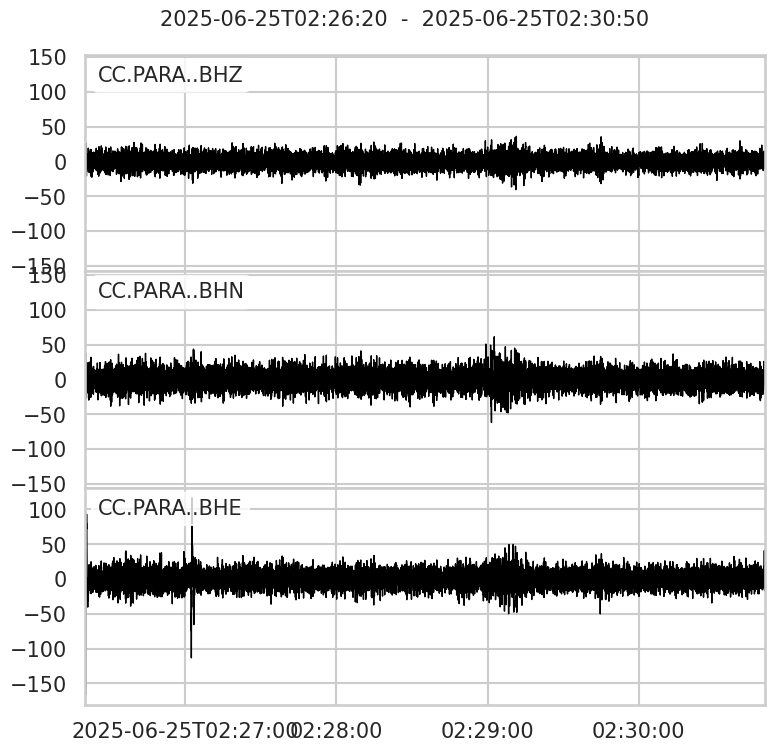

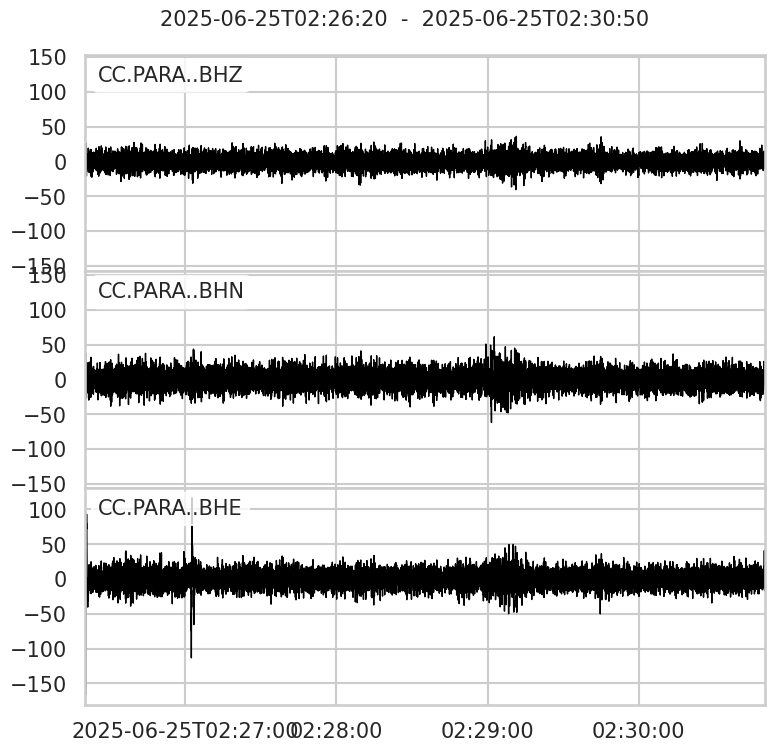

In [188]:
st.plot()

In [189]:
para_df

,starttime,endtime,label,date,max_prob,mean_prob,station
0,8880.0,8950.0,surface,2025-06-25,0.747395,0.464753,PARA
1,11800.0,11900.0,surface,2025-06-25,0.801149,0.461862,PARA
2,16000.0,16110.0,surface,2025-06-25,0.803666,0.498888,PARA
3,16610.0,16740.0,surface,2025-06-25,0.768179,0.517040,PARA
4,20250.0,20330.0,surface,2025-06-25,0.843076,0.472175,PARA
...,...,...,...,...,...,...,...
594,63340.0,63410.0,surface,2025-07-13,0.515436,0.343797,PARA
595,65230.0,65310.0,surface,2025-07-13,0.531536,0.328513,PARA
596,67080.0,67150.0,surface,2025-07-13,0.581863,0.385889,PARA
597,72960.0,73080.0,surface,2025-07-13,0.526313,0.271668,PARA


In [190]:
import pandas as pd

rcm_df  = rcm_df .assign(station='RCM')
para_df = para_df.assign(station='PARA')
star_df = star_df.assign(station='STAR')

df_all = pd.concat([rcm_df, para_df, star_df], ignore_index=True)


In [191]:
# one IntervalIndex per station, per date
iv_dict = {}                            # key: (station, date) -> dataframe with interval index

for (st, day), g in df_all.groupby(['station', 'date']):
    g = g.copy()
    g['interval'] = pd.IntervalIndex.from_arrays(g['starttime'], g['endtime'], closed='both')
    g.set_index('interval', inplace=True)
    iv_dict[(st, day)] = g              # rows are still accessible via .loc[Interval]


In [194]:
def add_probs(common, station_code, suffix):
    rows = []
    for _, row in common.iterrows():
        if row['starttime'] > row['endtime']:
            continue  # skip this invalid row

        day   = row['date']
        iv    = pd.Interval(row['starttime'], row['endtime'], closed='both')
        try:
            hit = iv_dict[(station_code, day)].loc[iv]      # returns one or more rows
            # take the *first* hit (they should all correspond to same event)
            hit = hit.iloc[0]
            rows.append({'max': hit['max_prob'], 'mean': hit['mean_prob']})
        except KeyError:
            rows.append({'max': pd.NA, 'mean': pd.NA})      # station missing that day
    vals = pd.DataFrame(rows)
    common[f'max_prob_{suffix}']  = vals['max']
    common[f'mean_prob_{suffix}'] = vals['mean']
    return common


def add_probs(common, station_code, suffix):
    rows = []
    for _, row in common.iterrows():
        if row['starttime'] > row['endtime']:
            rows.append({'max': pd.NA, 'mean': pd.NA})
            continue

        day = row['date']
        try:
            iv = pd.Interval(row['starttime'], row['endtime'], closed='both')
            hit_rows = iv_dict[(station_code, day)].loc[iv]

            if isinstance(hit_rows, pd.Series):
                # If it’s a single row
                hit = hit_rows
            elif isinstance(hit_rows, pd.DataFrame):
                hit = hit_rows.iloc[0]  # Take first if multiple rows match
            else:
                raise ValueError("Unexpected hit_rows type")

            rows.append({'max': hit['max_prob'], 'mean': hit['mean_prob']})
        except (KeyError, IndexError, ValueError):
            # If key is missing or index fails
            rows.append({'max': pd.NA, 'mean': pd.NA})

    vals = pd.DataFrame(rows)
    common[f'max_prob_{suffix}'] = vals['max']
    common[f'mean_prob_{suffix}'] = vals['mean']
    return common


common_df = add_probs(common_df, 'RCM',  'RCM')
common_df = add_probs(common_df, 'PARA', 'PARA')
common_df = add_probs(common_df, 'STAR', 'STAR')


In [195]:
common_df

,date,starttime,endtime,max_prob_RCM,mean_prob_RCM,max_prob_PARA,mean_prob_PARA,max_prob_STAR,mean_prob_STAR
0,2025-06-25,8880.0,8950.0,<NA>,<NA>,0.747395,0.464753,<NA>,<NA>
1,2025-06-25,16010.0,16110.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2025-06-25,16610.0,16740.0,<NA>,<NA>,0.768179,0.51704,<NA>,<NA>
3,2025-06-25,16630.0,16730.0,<NA>,<NA>,<NA>,<NA>,0.589042,0.369876
4,2025-06-25,21180.0,21210.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
172,2025-07-13,24470.0,24540.0,<NA>,<NA>,<NA>,<NA>,0.695352,0.427661
173,2025-07-13,25840.0,25820.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
174,2025-07-13,30280.0,30300.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
175,2025-07-13,35440.0,35510.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [196]:
common_df

,date,starttime,endtime,max_prob_RCM,mean_prob_RCM,max_prob_PARA,mean_prob_PARA,max_prob_STAR,mean_prob_STAR
0,2025-06-25,8880.0,8950.0,<NA>,<NA>,0.747395,0.464753,<NA>,<NA>
1,2025-06-25,16010.0,16110.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2025-06-25,16610.0,16740.0,<NA>,<NA>,0.768179,0.51704,<NA>,<NA>
3,2025-06-25,16630.0,16730.0,<NA>,<NA>,<NA>,<NA>,0.589042,0.369876
4,2025-06-25,21180.0,21210.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...
172,2025-07-13,24470.0,24540.0,<NA>,<NA>,<NA>,<NA>,0.695352,0.427661
173,2025-07-13,25840.0,25820.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
174,2025-07-13,30280.0,30300.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
175,2025-07-13,35440.0,35510.0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
